In [1]:
import tensorflow as tf
import scipy as sp
from scipy import ndimage
import numpy as np
import os
import sklearn
import imageio
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# The inputs and outptus are the maps downloaded from https://www.nnvl.noaa.gov/view/globaldata.html
# The inputs to the model are Land Surface Temperature, Moisture and Longwave Energy. 
# The output is the average precipitation map. 
# All maps are in the average weekly format. The idea is to find correlation between the input maps and 
# the output. 

input_labels = ['fire', 'frac', 'land', 'moisture', 'ndvi', 'longwave_energy'];
files = ['./fire_data.txt', './frac_data.txt', './land_data.txt', './mois_data.txt', './ndvi_data.txt', './olwr_data.txt']
input_dict = {}

#xdim = 256
xdim = 168
ydim = 512
in_chan = 6
out_chan = 1

# Process the input : input_metrics will contain a 2048 x 4096 image with 9 channels (corresponding to 3 inputs)

for label, path in zip(input_labels, files):
    
    input_dict[label] = [];
    input_dict[label] = (np.loadtxt(path,delimiter=',').reshape(-1,xdim,ydim,1))
    print(label, path,input_dict[label].shape)

input_metrics = input_dict[input_labels[0]];
for label in (input_labels[1:]):
    input_metrics = np.concatenate((input_metrics, input_dict[label]), axis=3);

# Process the output : output_metric will contain a 256 x 4096 image with 3 channels
path = './rain_data.txt'
output_metric = (np.loadtxt(path, delimiter=',').reshape(-1,xdim,ydim,1))
output_metric = np.array(output_metric);
samples = input_metrics.shape[0];

print(input_metrics.shape)
print(output_metric.shape)


('fire', './fire_data.txt', (89, 168, 512, 1))
('frac', './frac_data.txt', (89, 168, 512, 1))
('land', './land_data.txt', (89, 168, 512, 1))
('moisture', './mois_data.txt', (89, 168, 512, 1))
('ndvi', './ndvi_data.txt', (89, 168, 512, 1))
('longwave_energy', './olwr_data.txt', (89, 168, 512, 1))
(89, 168, 512, 6)
(89, 168, 512, 1)


In [3]:
# Function to obtain the next batch based on the input size and the batch size
def next_batch(indices, i):
    
    ind0, ind1 = i*batch_size, np.minimum((i+1)*batch_size, samples)
            
    return input_metrics[indices[ind0:ind1], :, :, :], output_metric[indices[ind0:ind1], :, :, :]

In [4]:
# Building a simple CNN model that looks like an auto-encoder. This is the section to change for a new model.

def conv_net(x):
    
    x = tf.reshape(x, shape=[-1, xdim, ydim, in_chan], name='reshape_x');
    x = tf.cast(x, tf.float32) 
    
    # Encoder
    # Scale down by 2x2. Out Channels = 32
    conv1 = tf.nn.relu(tf.contrib.layers.conv2d(x, 32, [8, 8], stride=2, padding='SAME', 
                                                biases_initializer=tf.zeros_initializer()))
    # Scale down by 2x2. Out Channels = 16
    conv2 = tf.nn.relu(tf.contrib.layers.conv2d(conv1, 16, [8, 8], stride=2, padding='SAME', 
                                                biases_initializer=tf.zeros_initializer()))
    # Scale down by 2x2. Out Channels = 8
    conv3 = tf.nn.relu(tf.contrib.layers.conv2d(conv2, 8, [8, 8], stride=2, padding='SAME', 
                                                biases_initializer=tf.zeros_initializer()))
    
    # Decoder
    # Scale up by 2x2. Out Channels = 16
    conv4 = tf.nn.relu(tf.contrib.layers.conv2d_transpose(conv3, 16, [8, 8], stride=2, padding='SAME',
                                                         biases_initializer=tf.zeros_initializer()))
    # Scale up by 2x2. Out Channels = 32
    conv5 = tf.nn.relu(tf.contrib.layers.conv2d_transpose(conv4, 32, [8, 8], stride=2, padding='SAME',
                                                         biases_initializer=tf.zeros_initializer()))
    # Scale up by 2x2. Out Channels = 1
    conv6 = tf.nn.relu(tf.contrib.layers.conv2d_transpose(conv5, out_chan, [8, 8], stride=2, padding='SAME',
                                                         biases_initializer=tf.zeros_initializer()))
    
    return conv6;

Y = tf.placeholder(tf.float32, shape=(None,xdim,ydim,out_chan));
X = tf.placeholder(tf.float32, shape=[None,xdim,ydim,in_chan]);

optimizer = tf.train.AdamOptimizer(learning_rate=0.001);

out = conv_net(X);
loss_op = tf.reduce_sum(tf.multiply(Y-out,Y-out));
train_op = optimizer.minimize(loss_op);

In [5]:
# Load colorbar for rain
color_bar = imageio.imread('rain_colorbar.png')
color_bar = color_bar[0, :, 0:3].astype(float)

c_n = np.shape(color_bar)[0]

color_bar_data = np.exp(np.linspace(np.log(1), np.log(375), c_n)).reshape((c_n, 1, 1, 1))
color_bar_data = (color_bar_data - 1) / (375 - 1)

# Function for reconstructing rain image based on output from network
def generate_rainfall_images(rain_data, filename):
    ind = np.argmin(abs(color_bar_data - rain_data), axis=0)
    
    rain_image = np.uint8(color_bar[ind, :].reshape((xdim, ydim, 3)).astype(int))
    
    imageio.imwrite(filename, rain_image)

In [6]:
num_epochs = 20;
batch_size = 8;
num_batches = int(np.ceil(float(samples) / batch_size));
print(num_batches)

loss_arr = [];

with tf.Session() as sess:
    
    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        indices = np.random.permutation(samples);
        
        # Compute the loss across all the batches
        total_loss = 0;
        for i in range(num_batches):
            x_train, y_train = next_batch(indices, i);
            [loss, train] = sess.run([loss_op, train_op], feed_dict={X: x_train, Y: y_train});            
            total_loss += loss;
        
        loss_arr.append(total_loss / num_batches);
        print(epoch, total_loss / num_batches);
    
    # Make rain plots from network outputs
    N_images = 5;
    idx_image = np.random.permutation(samples)[:N_images];
    for i in range(N_images):
        x_test = input_metrics[idx_image[i], :, :, :].reshape((1, xdim, ydim, in_chan))
        y_test = output_metric[idx_image[i], :, :, :].reshape((1, xdim, ydim, out_chan))
        
        [output_data] = sess.run([out], feed_dict={X: x_test, Y: y_test});
        
        generate_rainfall_images(output_data, 'rainfall' + str(i) + '_generated.png')
        generate_rainfall_images(y_test, 'rainfall' + str(i) + '_true.png')

12
(0, 17010.279439290363)
(1, 14028.38466389974)
(2, 13099.184122721354)
(3, 12799.240091959635)
(4, 12949.747273763021)
(5, 12778.912780761719)
(6, 12744.604614257812)
(7, 12568.683756510416)
(8, 12461.961822509766)
(9, 12450.338979085287)
(10, 12277.009552001953)
(11, 12197.194559733072)
(12, 12121.217854817709)
(13, 12095.586344401041)
(14, 11980.418009440104)
(15, 11954.718729654947)
(16, 11919.078160603842)
(17, 11896.457641601562)
(18, 11970.029012044271)
(19, 11858.743835449219)


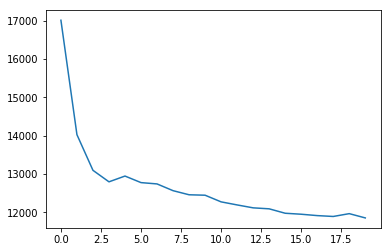

In [7]:
plt.plot(loss_arr);